# Model Performance Test


In [1]:
from dtsp.dataset import walk_forward_split, Seq2SeqDataSet, SimpleSeq2SeqDataSet, SimpleWaveNetDataSet
from dtsp.models import Seq2Seq, SimpleSeq2Seq, SimpleWaveNet
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pathlib import Path
import shutil
import seaborn as sns

%matplotlib inline

def plot_attentions(attns):
    if attns.ndim == 4:
        assert attns.shape[0] == 1
        attns = attns.squeeze(0)
    if isinstance(attns, torch.Tensor):
        attns = attns.detach().numpy()
    n_head = attns.shape[1]
    
    base_size = 12
    
    hight = attns.shape[0]
    wide = attns.shape[2]
    for i in range(n_head):
        plt.figure(figsize=(16, hight / wide * 16))
        sns.heatmap(attns[:, i, :])
        plt.title(f"Attention {i}")
        plt.xlabel('history')
        plt.ylabel('prediction')


def plot_prediction(enc, y_pred, y_true):
    f = plt.figure(figsize=(12, 4))
    enc_lens = len(enc)
    dec_lens = len(y_pred)
    plt.plot(enc)
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_pred, label='prediction', linestyle='--')
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_true, label='true')
    plt.legend()

In [2]:
torch.__version__

'1.3.0'

## 1. prepare dataset

In [3]:
df = pd.read_csv('./data.csv', index_col='date_time', parse_dates=['date_time'])
series = df.values
month = df.index.month.values
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
date_time,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0


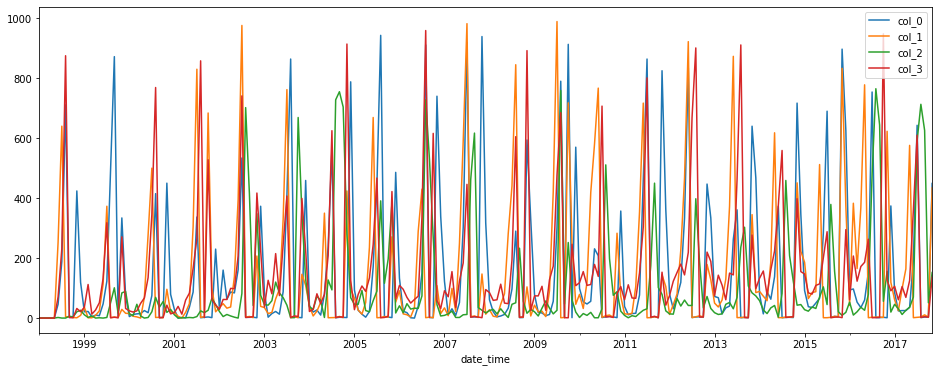

In [4]:
df.iloc[:, :4].plot(figsize=(16, 6))

**Target**

In [5]:
n_test = 12
n_val = 12
enc_lens = 72
dec_lens = 12
batch_size = 8
epochs = 100

## 1. Simple Seq2Seq Model

In [6]:
dataset = SimpleSeq2SeqDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.2,
        'hidden_size': 72,
        'teacher_forcing_rate': 0.5,
        'learning_rate': 0.001,
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = SimpleSeq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 1.107: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.51it/s]


epoch 1 / 100: train loss 1.078 val loss 1.200 RMSE 181.666
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.852: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.07it/s]


epoch 2 / 100: train loss 0.921 val loss 0.990 RMSE 168.158


batch 17 / 17, loss 1.065: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.73it/s]


epoch 3 / 100: train loss 0.851 val loss 0.953 RMSE 165.688


batch 17 / 17, loss 0.700: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.12it/s]


epoch 4 / 100: train loss 0.807 val loss 0.950 RMSE 165.235


batch 17 / 17, loss 0.763: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.46it/s]


epoch 5 / 100: train loss 0.792 val loss 0.945 RMSE 164.849


batch 17 / 17, loss 0.706: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.19it/s]


epoch 6 / 100: train loss 0.806 val loss 0.911 RMSE 161.166


batch 17 / 17, loss 0.622: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.15it/s]


epoch 7 / 100: train loss 0.716 val loss 0.854 RMSE 155.635


batch 17 / 17, loss 0.977: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.82it/s]


epoch 8 / 100: train loss 0.712 val loss 0.835 RMSE 152.785


batch 17 / 17, loss 0.746: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.68it/s]


epoch 9 / 100: train loss 0.695 val loss 0.817 RMSE 151.295


batch 17 / 17, loss 0.605: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.61it/s]


epoch 10 / 100: train loss 0.680 val loss 0.820 RMSE 151.422


batch 17 / 17, loss 0.727: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.05it/s]


epoch 11 / 100: train loss 0.663 val loss 0.840 RMSE 153.560


batch 17 / 17, loss 0.612: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.57it/s]


epoch 12 / 100: train loss 0.644 val loss 0.795 RMSE 148.451


batch 17 / 17, loss 0.528: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.80it/s]


epoch 13 / 100: train loss 0.634 val loss 0.785 RMSE 147.252


batch 17 / 17, loss 0.618: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.20it/s]


epoch 14 / 100: train loss 0.616 val loss 0.791 RMSE 148.245


batch 17 / 17, loss 0.484: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.28it/s]


epoch 15 / 100: train loss 0.578 val loss 0.772 RMSE 146.209


batch 17 / 17, loss 0.664: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.54it/s]


epoch 16 / 100: train loss 0.579 val loss 0.774 RMSE 146.568


batch 17 / 17, loss 0.496: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.94it/s]


epoch 17 / 100: train loss 0.560 val loss 0.755 RMSE 143.778


batch 17 / 17, loss 0.518: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.79it/s]


epoch 18 / 100: train loss 0.547 val loss 0.767 RMSE 146.977


batch 17 / 17, loss 0.536: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.34it/s]


epoch 19 / 100: train loss 0.552 val loss 0.758 RMSE 144.978


batch 17 / 17, loss 0.525: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.66it/s]


epoch 20 / 100: train loss 0.523 val loss 0.738 RMSE 143.140


batch 17 / 17, loss 0.773: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.27it/s]


epoch 21 / 100: train loss 0.543 val loss 0.772 RMSE 146.414


batch 17 / 17, loss 0.629: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.15it/s]


epoch 22 / 100: train loss 0.523 val loss 0.725 RMSE 141.848


batch 17 / 17, loss 0.580: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.32it/s]


epoch 23 / 100: train loss 0.536 val loss 0.841 RMSE 155.409


batch 17 / 17, loss 0.451: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.87it/s]


epoch 24 / 100: train loss 0.528 val loss 0.726 RMSE 141.215


batch 17 / 17, loss 0.539: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.28it/s]


epoch 25 / 100: train loss 0.521 val loss 0.709 RMSE 140.208


batch 17 / 17, loss 0.601: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.84it/s]


epoch 26 / 100: train loss 0.491 val loss 0.699 RMSE 138.545


batch 17 / 17, loss 0.572: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.84it/s]


epoch 27 / 100: train loss 0.492 val loss 0.708 RMSE 139.673


batch 17 / 17, loss 0.449: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.77it/s]


epoch 28 / 100: train loss 0.498 val loss 0.698 RMSE 138.498


batch 17 / 17, loss 0.539: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.35it/s]


epoch 29 / 100: train loss 0.476 val loss 0.682 RMSE 136.649


batch 17 / 17, loss 0.472: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.64it/s]


epoch 30 / 100: train loss 0.454 val loss 0.676 RMSE 135.778


batch 17 / 17, loss 0.424: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.98it/s]


epoch 31 / 100: train loss 0.481 val loss 0.680 RMSE 136.823


batch 17 / 17, loss 0.483: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.04it/s]


epoch 32 / 100: train loss 0.432 val loss 0.676 RMSE 135.584


batch 17 / 17, loss 0.540: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.29it/s]


epoch 33 / 100: train loss 0.456 val loss 0.674 RMSE 135.673


batch 17 / 17, loss 0.495: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.96it/s]


epoch 34 / 100: train loss 0.454 val loss 0.668 RMSE 134.457


batch 17 / 17, loss 0.484: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.46it/s]


epoch 35 / 100: train loss 0.456 val loss 0.662 RMSE 133.644


batch 17 / 17, loss 0.379: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.08it/s]


epoch 36 / 100: train loss 0.446 val loss 0.659 RMSE 133.630


batch 17 / 17, loss 0.502: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.33it/s]


epoch 37 / 100: train loss 0.432 val loss 0.659 RMSE 133.499


batch 17 / 17, loss 0.382: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.56it/s]


epoch 38 / 100: train loss 0.430 val loss 0.654 RMSE 133.397


batch 17 / 17, loss 0.398: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.01it/s]


epoch 39 / 100: train loss 0.428 val loss 0.653 RMSE 132.939


batch 17 / 17, loss 0.373: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.84it/s]


epoch 40 / 100: train loss 0.427 val loss 0.647 RMSE 132.487


batch 17 / 17, loss 0.459: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.75it/s]


epoch 41 / 100: train loss 0.432 val loss 0.644 RMSE 131.956


batch 17 / 17, loss 0.345: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.15it/s]


epoch 42 / 100: train loss 0.435 val loss 0.644 RMSE 131.945


batch 17 / 17, loss 0.346: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.27it/s]


epoch 43 / 100: train loss 0.429 val loss 0.639 RMSE 131.468


batch 17 / 17, loss 0.337: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.69it/s]


epoch 44 / 100: train loss 0.418 val loss 0.644 RMSE 131.748


batch 17 / 17, loss 0.390: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.44it/s]


epoch 45 / 100: train loss 0.425 val loss 0.642 RMSE 131.411


batch 17 / 17, loss 0.403: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.46it/s]


epoch 46 / 100: train loss 0.431 val loss 0.640 RMSE 131.322


batch 17 / 17, loss 0.420: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.34it/s]


epoch 47 / 100: train loss 0.411 val loss 0.640 RMSE 131.519


batch 17 / 17, loss 0.418: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.17it/s]


epoch 48 / 100: train loss 0.420 val loss 0.640 RMSE 131.307


batch 17 / 17, loss 0.403: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.04it/s]


epoch 49 / 100: train loss 0.431 val loss 0.639 RMSE 131.224


batch 17 / 17, loss 0.460: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.33it/s]


epoch 50 / 100: train loss 0.443 val loss 0.636 RMSE 130.952


batch 17 / 17, loss 0.409: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.79it/s]


epoch 51 / 100: train loss 0.412 val loss 0.636 RMSE 131.022


batch 17 / 17, loss 0.403: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.89it/s]


epoch 52 / 100: train loss 0.410 val loss 0.636 RMSE 131.044


batch 17 / 17, loss 0.395: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.05it/s]


epoch 53 / 100: train loss 0.426 val loss 0.637 RMSE 131.073


batch 17 / 17, loss 0.519: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.28it/s]


epoch 54 / 100: train loss 0.402 val loss 0.637 RMSE 131.075


batch 17 / 17, loss 0.446: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.22it/s]


epoch 55 / 100: train loss 0.424 val loss 0.637 RMSE 131.072


batch 17 / 17, loss 0.549: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.98it/s]


epoch 56 / 100: train loss 0.449 val loss 0.693 RMSE 138.449


batch 17 / 17, loss 0.378: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.39it/s]


epoch 57 / 100: train loss 0.433 val loss 0.766 RMSE 148.406


batch 17 / 17, loss 0.435: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.99it/s]


epoch 58 / 100: train loss 0.440 val loss 0.649 RMSE 132.500


batch 17 / 17, loss 0.320: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.79it/s]


epoch 59 / 100: train loss 0.411 val loss 0.643 RMSE 132.133


batch 17 / 17, loss 0.348: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.22it/s]


epoch 60 / 100: train loss 0.417 val loss 0.654 RMSE 132.846


batch 17 / 17, loss 0.355: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.89it/s]


epoch 61 / 100: train loss 0.384 val loss 0.639 RMSE 130.737


batch 17 / 17, loss 0.506: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.61it/s]


epoch 62 / 100: train loss 0.411 val loss 0.634 RMSE 129.725


batch 17 / 17, loss 0.317: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.71it/s]


epoch 63 / 100: train loss 0.389 val loss 0.653 RMSE 133.840


batch 17 / 17, loss 0.358: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.66it/s]


epoch 64 / 100: train loss 0.375 val loss 0.621 RMSE 127.961


batch 17 / 17, loss 0.402: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.68it/s]


epoch 65 / 100: train loss 0.401 val loss 0.616 RMSE 128.363


batch 17 / 17, loss 0.425: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.11it/s]


epoch 66 / 100: train loss 0.400 val loss 0.596 RMSE 125.468


batch 17 / 17, loss 0.287: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.29it/s]


epoch 67 / 100: train loss 0.361 val loss 0.624 RMSE 127.461


batch 17 / 17, loss 0.347: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.22it/s]


epoch 68 / 100: train loss 0.398 val loss 0.622 RMSE 128.115


batch 17 / 17, loss 0.325: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.84it/s]


epoch 69 / 100: train loss 0.353 val loss 0.596 RMSE 124.454


batch 17 / 17, loss 0.383: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.00it/s]


epoch 70 / 100: train loss 0.382 val loss 0.594 RMSE 124.302


batch 17 / 17, loss 0.306: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.89it/s]


epoch 71 / 100: train loss 0.356 val loss 0.644 RMSE 131.491


batch 17 / 17, loss 0.374: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.29it/s]


epoch 72 / 100: train loss 0.338 val loss 0.574 RMSE 121.458


batch 17 / 17, loss 0.283: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.75it/s]


epoch 73 / 100: train loss 0.351 val loss 0.580 RMSE 122.961


batch 17 / 17, loss 0.359: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.54it/s]


epoch 74 / 100: train loss 0.325 val loss 0.547 RMSE 117.723


batch 17 / 17, loss 0.244: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.36it/s]


epoch 75 / 100: train loss 0.300 val loss 0.569 RMSE 120.961


batch 17 / 17, loss 0.371: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.74it/s]


epoch 76 / 100: train loss 0.315 val loss 0.541 RMSE 116.596


batch 17 / 17, loss 0.382: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.97it/s]


epoch 77 / 100: train loss 0.304 val loss 0.563 RMSE 119.088


batch 17 / 17, loss 0.277: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.27it/s]


epoch 78 / 100: train loss 0.387 val loss 0.676 RMSE 135.810


batch 17 / 17, loss 0.476: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.71it/s]


epoch 79 / 100: train loss 0.376 val loss 0.632 RMSE 128.991


batch 17 / 17, loss 0.952: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.98it/s]


epoch 80 / 100: train loss 0.464 val loss 1.164 RMSE 192.272


batch 17 / 17, loss 0.462: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.05it/s]


epoch 81 / 100: train loss 0.519 val loss 0.593 RMSE 123.172


batch 17 / 17, loss 0.269: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.66it/s]


epoch 82 / 100: train loss 0.371 val loss 0.534 RMSE 115.847


batch 17 / 17, loss 0.227: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.22it/s]


epoch 83 / 100: train loss 0.324 val loss 0.532 RMSE 114.069


batch 17 / 17, loss 0.293: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.01it/s]


epoch 84 / 100: train loss 0.300 val loss 0.513 RMSE 111.983


batch 17 / 17, loss 0.249: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.07it/s]


epoch 85 / 100: train loss 0.260 val loss 0.493 RMSE 109.684


batch 17 / 17, loss 0.195: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.89it/s]


epoch 86 / 100: train loss 0.274 val loss 0.503 RMSE 109.258


batch 17 / 17, loss 0.399: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.87it/s]


epoch 87 / 100: train loss 0.282 val loss 0.498 RMSE 109.942


batch 17 / 17, loss 0.309: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.50it/s]


epoch 88 / 100: train loss 0.283 val loss 0.548 RMSE 116.797


batch 17 / 17, loss 0.207: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.51it/s]


epoch 89 / 100: train loss 0.272 val loss 0.504 RMSE 110.500


batch 17 / 17, loss 0.207: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.49it/s]


epoch 90 / 100: train loss 0.251 val loss 0.474 RMSE 104.941


batch 17 / 17, loss 0.195: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.94it/s]


epoch 91 / 100: train loss 0.254 val loss 0.470 RMSE 104.907


batch 17 / 17, loss 0.202: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.02it/s]


epoch 92 / 100: train loss 0.235 val loss 0.457 RMSE 102.354


batch 17 / 17, loss 0.200: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.52it/s]


epoch 93 / 100: train loss 0.219 val loss 0.445 RMSE 100.202


batch 17 / 17, loss 0.224: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.15it/s]


epoch 94 / 100: train loss 0.225 val loss 0.439 RMSE 98.904


batch 17 / 17, loss 0.181: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.59it/s]


epoch 95 / 100: train loss 0.228 val loss 0.446 RMSE 101.126


batch 17 / 17, loss 0.224: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.86it/s]


epoch 96 / 100: train loss 0.225 val loss 0.435 RMSE 97.566


batch 17 / 17, loss 0.210: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.51it/s]


epoch 97 / 100: train loss 0.221 val loss 0.428 RMSE 96.783


batch 17 / 17, loss 0.266: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.22it/s]


epoch 98 / 100: train loss 0.214 val loss 0.415 RMSE 94.826


batch 17 / 17, loss 0.221: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.30it/s]


epoch 99 / 100: train loss 0.219 val loss 0.422 RMSE 94.964


batch 17 / 17, loss 0.226: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 21.17it/s]


epoch 100 / 100: train loss 0.197 val loss 0.413 RMSE 93.771
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleSeq2Seq_epoch_100_0.413.pkl


In [8]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.185, valid loss: 0.413, test loss :0.522, test RMSE :108.133, 


Text(0.5, 1.0, 'Simple Seq2Seq prediction')

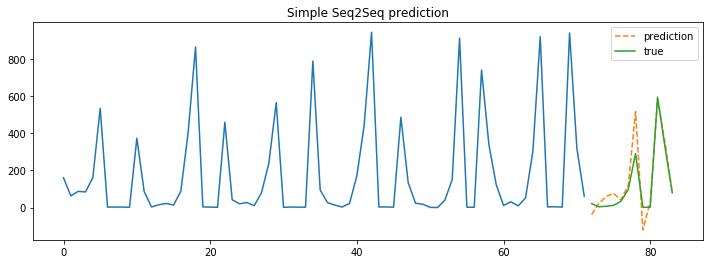

In [9]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Simple Seq2Seq prediction')

## 2. Seq2Seq(Attention 0)

In [10]:
dataset = Seq2SeqDataSet(series, enc_lens, dec_lens, categorical_var=month)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [11]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': False,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 1.034: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 1 / 100: train loss 0.946 val loss 0.970 RMSE 168.126
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.637: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.94it/s]


epoch 2 / 100: train loss 0.780 val loss 0.935 RMSE 163.359


batch 17 / 17, loss 0.677: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 3 / 100: train loss 0.720 val loss 0.870 RMSE 157.202


batch 17 / 17, loss 0.565: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.97it/s]


epoch 4 / 100: train loss 0.697 val loss 0.848 RMSE 154.996


batch 17 / 17, loss 0.710: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 5 / 100: train loss 0.675 val loss 0.847 RMSE 155.025


batch 17 / 17, loss 0.617: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.29it/s]


epoch 6 / 100: train loss 0.658 val loss 0.834 RMSE 152.313


batch 17 / 17, loss 0.614: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.15it/s]


epoch 7 / 100: train loss 0.657 val loss 0.808 RMSE 150.137


batch 17 / 17, loss 0.539: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 8 / 100: train loss 0.641 val loss 0.806 RMSE 150.608


batch 17 / 17, loss 0.592: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 9 / 100: train loss 0.601 val loss 0.788 RMSE 146.453


batch 17 / 17, loss 0.623: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.22it/s]


epoch 10 / 100: train loss 0.571 val loss 0.736 RMSE 141.964


batch 17 / 17, loss 0.598: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.28it/s]


epoch 11 / 100: train loss 0.526 val loss 0.742 RMSE 142.654


batch 17 / 17, loss 0.575: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 12 / 100: train loss 0.541 val loss 0.764 RMSE 143.378


batch 17 / 17, loss 0.547: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.30it/s]


epoch 13 / 100: train loss 0.500 val loss 0.695 RMSE 138.002


batch 17 / 17, loss 0.454: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.32it/s]


epoch 14 / 100: train loss 0.488 val loss 0.725 RMSE 140.185


batch 17 / 17, loss 0.479: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.05it/s]


epoch 15 / 100: train loss 0.485 val loss 0.665 RMSE 133.477


batch 17 / 17, loss 0.352: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.24it/s]


epoch 16 / 100: train loss 0.450 val loss 0.671 RMSE 135.948


batch 17 / 17, loss 0.435: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 17 / 100: train loss 0.434 val loss 0.637 RMSE 130.876


batch 17 / 17, loss 0.401: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.35it/s]


epoch 18 / 100: train loss 0.407 val loss 0.623 RMSE 128.914


batch 17 / 17, loss 0.495: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 19 / 100: train loss 0.392 val loss 0.619 RMSE 127.860


batch 17 / 17, loss 0.336: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.28it/s]


epoch 20 / 100: train loss 0.387 val loss 0.627 RMSE 129.722


batch 17 / 17, loss 0.270: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 21 / 100: train loss 0.358 val loss 0.578 RMSE 124.579


batch 17 / 17, loss 0.305: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.27it/s]


epoch 22 / 100: train loss 0.353 val loss 0.653 RMSE 134.314


batch 17 / 17, loss 0.502: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.35it/s]


epoch 23 / 100: train loss 0.365 val loss 0.616 RMSE 129.964


batch 17 / 17, loss 0.355: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 24 / 100: train loss 0.345 val loss 0.542 RMSE 118.389


batch 17 / 17, loss 0.234: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.28it/s]


epoch 25 / 100: train loss 0.315 val loss 0.542 RMSE 118.439


batch 17 / 17, loss 0.323: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.15it/s]


epoch 26 / 100: train loss 0.302 val loss 0.534 RMSE 117.675


batch 17 / 17, loss 0.349: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.13it/s]


epoch 27 / 100: train loss 0.290 val loss 0.506 RMSE 112.486


batch 17 / 17, loss 0.252: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 28 / 100: train loss 0.280 val loss 0.518 RMSE 113.881


batch 17 / 17, loss 0.263: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 29 / 100: train loss 0.270 val loss 0.508 RMSE 112.391


batch 17 / 17, loss 0.267: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.97it/s]


epoch 30 / 100: train loss 0.268 val loss 0.481 RMSE 108.488


batch 17 / 17, loss 0.284: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 31 / 100: train loss 0.248 val loss 0.457 RMSE 105.513


batch 17 / 17, loss 0.262: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.32it/s]


epoch 32 / 100: train loss 0.229 val loss 0.451 RMSE 103.957


batch 17 / 17, loss 0.263: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.15it/s]


epoch 33 / 100: train loss 0.233 val loss 0.444 RMSE 102.793


batch 17 / 17, loss 0.242: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 34 / 100: train loss 0.235 val loss 0.435 RMSE 101.460


batch 17 / 17, loss 0.171: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.06it/s]


epoch 35 / 100: train loss 0.228 val loss 0.431 RMSE 100.484


batch 17 / 17, loss 0.222: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.26it/s]


epoch 36 / 100: train loss 0.209 val loss 0.425 RMSE 99.411


batch 17 / 17, loss 0.186: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 37 / 100: train loss 0.202 val loss 0.417 RMSE 97.844


batch 17 / 17, loss 0.182: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.96it/s]


epoch 38 / 100: train loss 0.215 val loss 0.407 RMSE 95.990


batch 17 / 17, loss 0.196: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 39 / 100: train loss 0.205 val loss 0.401 RMSE 94.999


batch 17 / 17, loss 0.164: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 40 / 100: train loss 0.197 val loss 0.395 RMSE 93.714


batch 17 / 17, loss 0.196: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 41 / 100: train loss 0.187 val loss 0.394 RMSE 93.135


batch 17 / 17, loss 0.167: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 42 / 100: train loss 0.187 val loss 0.391 RMSE 92.283


batch 17 / 17, loss 0.154: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 43 / 100: train loss 0.178 val loss 0.392 RMSE 92.613


batch 17 / 17, loss 0.200: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.27it/s]


epoch 44 / 100: train loss 0.185 val loss 0.385 RMSE 91.432


batch 17 / 17, loss 0.157: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.30it/s]


epoch 45 / 100: train loss 0.172 val loss 0.383 RMSE 91.272


batch 17 / 17, loss 0.158: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 46 / 100: train loss 0.179 val loss 0.380 RMSE 90.510


batch 17 / 17, loss 0.151: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 47 / 100: train loss 0.178 val loss 0.376 RMSE 90.118


batch 17 / 17, loss 0.164: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.23it/s]


epoch 48 / 100: train loss 0.176 val loss 0.377 RMSE 89.995


batch 17 / 17, loss 0.186: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 49 / 100: train loss 0.176 val loss 0.377 RMSE 89.941


batch 17 / 17, loss 0.161: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.42it/s]


epoch 50 / 100: train loss 0.171 val loss 0.375 RMSE 89.761


batch 17 / 17, loss 0.185: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 51 / 100: train loss 0.172 val loss 0.374 RMSE 89.609


batch 17 / 17, loss 0.128: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.37it/s]


epoch 52 / 100: train loss 0.168 val loss 0.374 RMSE 89.644


batch 17 / 17, loss 0.129: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 53 / 100: train loss 0.172 val loss 0.374 RMSE 89.574


batch 17 / 17, loss 0.188: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 54 / 100: train loss 0.175 val loss 0.374 RMSE 89.531


batch 17 / 17, loss 0.247: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 55 / 100: train loss 0.171 val loss 0.374 RMSE 89.530


batch 17 / 17, loss 0.200: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.27it/s]


epoch 56 / 100: train loss 0.179 val loss 0.423 RMSE 99.342


batch 17 / 17, loss 0.237: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.18it/s]


epoch 57 / 100: train loss 0.299 val loss 0.542 RMSE 114.381


batch 17 / 17, loss 0.166: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.06it/s]


epoch 58 / 100: train loss 0.260 val loss 0.429 RMSE 96.706


batch 17 / 17, loss 0.142: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.15it/s]


epoch 59 / 100: train loss 0.205 val loss 0.414 RMSE 94.672


batch 17 / 17, loss 0.206: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 60 / 100: train loss 0.178 val loss 0.432 RMSE 99.152


batch 17 / 17, loss 0.144: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 61 / 100: train loss 0.189 val loss 0.418 RMSE 97.426


batch 17 / 17, loss 0.488: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.06it/s]


epoch 62 / 100: train loss 0.258 val loss 0.466 RMSE 106.903


batch 17 / 17, loss 0.183: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.00it/s]


epoch 63 / 100: train loss 0.289 val loss 0.384 RMSE 93.299
early_stopping ! current epochs: 63, best epochs: 51.
model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_51_0.374.pkl


In [12]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.168, valid loss: 0.374, test loss :0.483, test RMSE :104.498, 


Text(0.5, 1.0, 'Seq2Seq 0 Attention prediction')

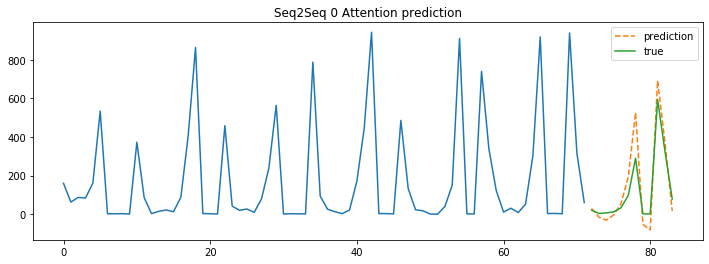

In [13]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 0 Attention prediction')

## 3. Seq2Seq(Attention 1)

In [14]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 1,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.694: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.73it/s]


epoch 1 / 100: train loss 0.985 val loss 0.944 RMSE 164.943
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.710: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.17it/s]


epoch 2 / 100: train loss 0.776 val loss 0.914 RMSE 160.868


batch 17 / 17, loss 0.664: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 3 / 100: train loss 0.718 val loss 0.852 RMSE 154.783


batch 17 / 17, loss 0.965: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 4 / 100: train loss 0.696 val loss 0.831 RMSE 152.404


batch 17 / 17, loss 0.637: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.65it/s]


epoch 5 / 100: train loss 0.680 val loss 0.828 RMSE 152.229


batch 17 / 17, loss 0.596: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.72it/s]


epoch 6 / 100: train loss 0.668 val loss 0.804 RMSE 150.332


batch 17 / 17, loss 0.597: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 7 / 100: train loss 0.634 val loss 0.771 RMSE 146.461


batch 17 / 17, loss 0.536: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 8 / 100: train loss 0.594 val loss 0.756 RMSE 145.973


batch 17 / 17, loss 0.503: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 9 / 100: train loss 0.586 val loss 0.810 RMSE 149.101


batch 17 / 17, loss 0.453: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.23it/s]


epoch 10 / 100: train loss 0.532 val loss 0.741 RMSE 145.487


batch 17 / 17, loss 0.457: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.64it/s]


epoch 11 / 100: train loss 0.519 val loss 0.683 RMSE 138.110


batch 17 / 17, loss 0.471: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 12 / 100: train loss 0.501 val loss 0.926 RMSE 162.233


batch 17 / 17, loss 0.485: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.51it/s]


epoch 13 / 100: train loss 0.477 val loss 0.667 RMSE 136.472


batch 17 / 17, loss 0.371: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 14 / 100: train loss 0.459 val loss 0.663 RMSE 133.628


batch 17 / 17, loss 0.387: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.45it/s]


epoch 15 / 100: train loss 0.416 val loss 0.627 RMSE 130.358


batch 17 / 17, loss 0.311: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.85it/s]


epoch 16 / 100: train loss 0.422 val loss 0.615 RMSE 128.957


batch 17 / 17, loss 0.338: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.97it/s]


epoch 17 / 100: train loss 0.385 val loss 0.639 RMSE 132.517


batch 17 / 17, loss 0.389: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.51it/s]


epoch 18 / 100: train loss 0.349 val loss 0.597 RMSE 125.096


batch 17 / 17, loss 0.366: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.16it/s]


epoch 19 / 100: train loss 0.335 val loss 0.560 RMSE 120.665


batch 17 / 17, loss 0.341: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.69it/s]


epoch 20 / 100: train loss 0.298 val loss 0.549 RMSE 119.020


batch 17 / 17, loss 0.234: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.42it/s]


epoch 21 / 100: train loss 0.334 val loss 0.527 RMSE 116.709


batch 17 / 17, loss 0.224: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 22 / 100: train loss 0.293 val loss 0.490 RMSE 112.409


batch 17 / 17, loss 0.288: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.12it/s]


epoch 23 / 100: train loss 0.275 val loss 0.508 RMSE 111.829


batch 17 / 17, loss 0.326: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.04it/s]


epoch 24 / 100: train loss 0.255 val loss 0.470 RMSE 107.184


batch 17 / 17, loss 0.236: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.56it/s]


epoch 25 / 100: train loss 0.265 val loss 0.469 RMSE 104.299


batch 17 / 17, loss 0.223: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.19it/s]


epoch 26 / 100: train loss 0.235 val loss 0.430 RMSE 99.712


batch 17 / 17, loss 0.227: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 27 / 100: train loss 0.224 val loss 0.429 RMSE 98.309


batch 17 / 17, loss 0.158: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 28 / 100: train loss 0.200 val loss 0.443 RMSE 101.917


batch 17 / 17, loss 0.239: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.90it/s]


epoch 29 / 100: train loss 0.211 val loss 0.405 RMSE 96.260


batch 17 / 17, loss 0.165: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.21it/s]


epoch 30 / 100: train loss 0.193 val loss 0.384 RMSE 91.675


batch 17 / 17, loss 0.154: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.30it/s]


epoch 31 / 100: train loss 0.184 val loss 0.369 RMSE 87.893


batch 17 / 17, loss 0.215: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 32 / 100: train loss 0.176 val loss 0.357 RMSE 85.412


batch 17 / 17, loss 0.134: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.31it/s]


epoch 33 / 100: train loss 0.161 val loss 0.346 RMSE 83.325


batch 17 / 17, loss 0.128: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 34 / 100: train loss 0.156 val loss 0.346 RMSE 82.995


batch 17 / 17, loss 0.134: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 35 / 100: train loss 0.154 val loss 0.340 RMSE 80.666


batch 17 / 17, loss 0.138: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.23it/s]


epoch 36 / 100: train loss 0.146 val loss 0.337 RMSE 80.427


batch 17 / 17, loss 0.124: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 37 / 100: train loss 0.140 val loss 0.333 RMSE 80.333


batch 17 / 17, loss 0.144: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.98it/s]


epoch 38 / 100: train loss 0.139 val loss 0.324 RMSE 77.841


batch 17 / 17, loss 0.118: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.13it/s]


epoch 39 / 100: train loss 0.135 val loss 0.311 RMSE 76.157


batch 17 / 17, loss 0.133: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.73it/s]


epoch 40 / 100: train loss 0.133 val loss 0.309 RMSE 75.043


batch 17 / 17, loss 0.119: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.03it/s]


epoch 41 / 100: train loss 0.128 val loss 0.306 RMSE 74.841


batch 17 / 17, loss 0.112: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.36it/s]


epoch 42 / 100: train loss 0.129 val loss 0.302 RMSE 73.574


batch 17 / 17, loss 0.103: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.69it/s]


epoch 43 / 100: train loss 0.126 val loss 0.298 RMSE 72.898


batch 17 / 17, loss 0.124: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.09it/s]


epoch 44 / 100: train loss 0.124 val loss 0.298 RMSE 73.725


batch 17 / 17, loss 0.108: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 45 / 100: train loss 0.120 val loss 0.295 RMSE 72.941


batch 17 / 17, loss 0.118: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 46 / 100: train loss 0.122 val loss 0.293 RMSE 72.200


batch 17 / 17, loss 0.256: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 47 / 100: train loss 0.119 val loss 0.295 RMSE 72.312


batch 17 / 17, loss 0.114: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.74it/s]


epoch 48 / 100: train loss 0.119 val loss 0.290 RMSE 71.720


batch 17 / 17, loss 0.101: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.86it/s]


epoch 49 / 100: train loss 0.117 val loss 0.290 RMSE 71.471


batch 17 / 17, loss 0.105: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 50 / 100: train loss 0.115 val loss 0.288 RMSE 71.286


batch 17 / 17, loss 0.142: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.81it/s]


epoch 51 / 100: train loss 0.118 val loss 0.289 RMSE 71.439


batch 17 / 17, loss 0.117: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.81it/s]


epoch 52 / 100: train loss 0.117 val loss 0.289 RMSE 71.328


batch 17 / 17, loss 0.125: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.61it/s]


epoch 53 / 100: train loss 0.117 val loss 0.288 RMSE 71.239


batch 17 / 17, loss 0.093: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 54 / 100: train loss 0.115 val loss 0.288 RMSE 71.180


batch 17 / 17, loss 0.100: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 55 / 100: train loss 0.116 val loss 0.288 RMSE 71.174


batch 17 / 17, loss 0.235: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.58it/s]


epoch 56 / 100: train loss 0.135 val loss 0.438 RMSE 104.588


batch 17 / 17, loss 0.285: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.09it/s]


epoch 57 / 100: train loss 0.340 val loss 0.595 RMSE 125.142


batch 17 / 17, loss 0.330: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 58 / 100: train loss 0.268 val loss 0.441 RMSE 103.245


batch 17 / 17, loss 0.157: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 59 / 100: train loss 0.197 val loss 0.337 RMSE 83.489


batch 17 / 17, loss 0.169: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.26it/s]


epoch 60 / 100: train loss 0.154 val loss 0.314 RMSE 80.814


batch 17 / 17, loss 0.113: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.09it/s]


epoch 61 / 100: train loss 0.131 val loss 0.307 RMSE 75.666


batch 17 / 17, loss 0.081: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 62 / 100: train loss 0.110 val loss 0.279 RMSE 70.100


batch 17 / 17, loss 0.095: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.49it/s]


epoch 63 / 100: train loss 0.103 val loss 0.272 RMSE 70.400


batch 17 / 17, loss 0.081: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.37it/s]


epoch 64 / 100: train loss 0.094 val loss 0.291 RMSE 76.614


batch 17 / 17, loss 0.190: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 65 / 100: train loss 0.104 val loss 0.293 RMSE 76.248


batch 17 / 17, loss 0.107: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.04it/s]


epoch 66 / 100: train loss 0.134 val loss 0.277 RMSE 72.307


batch 17 / 17, loss 0.094: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.80it/s]


epoch 67 / 100: train loss 0.118 val loss 0.255 RMSE 65.112


batch 17 / 17, loss 0.078: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 68 / 100: train loss 0.091 val loss 0.240 RMSE 61.743


batch 17 / 17, loss 0.085: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 69 / 100: train loss 0.084 val loss 0.228 RMSE 58.821


batch 17 / 17, loss 0.087: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 70 / 100: train loss 0.076 val loss 0.226 RMSE 57.863


batch 17 / 17, loss 0.075: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 71 / 100: train loss 0.072 val loss 0.233 RMSE 57.581


batch 17 / 17, loss 0.064: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 72 / 100: train loss 0.072 val loss 0.222 RMSE 56.973


batch 17 / 17, loss 0.075: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.76it/s]


epoch 73 / 100: train loss 0.070 val loss 0.226 RMSE 57.071


batch 17 / 17, loss 0.051: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.85it/s]


epoch 74 / 100: train loss 0.068 val loss 0.221 RMSE 54.981


batch 17 / 17, loss 0.065: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.84it/s]


epoch 75 / 100: train loss 0.064 val loss 0.220 RMSE 54.914


batch 17 / 17, loss 0.104: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.00it/s]


epoch 76 / 100: train loss 0.063 val loss 0.217 RMSE 54.102


batch 17 / 17, loss 0.052: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.08it/s]


epoch 77 / 100: train loss 0.060 val loss 0.207 RMSE 52.733


batch 17 / 17, loss 0.049: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.32it/s]


epoch 78 / 100: train loss 0.056 val loss 0.215 RMSE 53.594


batch 17 / 17, loss 0.067: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.98it/s]


epoch 79 / 100: train loss 0.057 val loss 0.205 RMSE 51.112


batch 17 / 17, loss 0.062: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.67it/s]


epoch 80 / 100: train loss 0.054 val loss 0.210 RMSE 51.614


batch 17 / 17, loss 0.051: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.74it/s]


epoch 81 / 100: train loss 0.051 val loss 0.204 RMSE 53.609


batch 17 / 17, loss 0.055: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.84it/s]


epoch 82 / 100: train loss 0.055 val loss 0.224 RMSE 55.986


batch 17 / 17, loss 0.040: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.16it/s]


epoch 83 / 100: train loss 0.050 val loss 0.211 RMSE 51.575


batch 17 / 17, loss 0.046: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.74it/s]


epoch 84 / 100: train loss 0.051 val loss 0.207 RMSE 49.581


batch 17 / 17, loss 0.044: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.26it/s]


epoch 85 / 100: train loss 0.047 val loss 0.204 RMSE 50.218


batch 17 / 17, loss 0.048: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.15it/s]


epoch 86 / 100: train loss 0.047 val loss 0.199 RMSE 48.941


batch 17 / 17, loss 0.044: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.08it/s]


epoch 87 / 100: train loss 0.046 val loss 0.201 RMSE 48.469


batch 17 / 17, loss 0.032: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.19it/s]


epoch 88 / 100: train loss 0.043 val loss 0.199 RMSE 48.136


batch 17 / 17, loss 0.044: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.41it/s]


epoch 89 / 100: train loss 0.046 val loss 0.198 RMSE 47.070


batch 17 / 17, loss 0.049: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.00it/s]


epoch 90 / 100: train loss 0.044 val loss 0.199 RMSE 47.492


batch 17 / 17, loss 0.034: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.26it/s]


epoch 91 / 100: train loss 0.044 val loss 0.196 RMSE 50.966


batch 17 / 17, loss 0.041: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.14it/s]


epoch 92 / 100: train loss 0.045 val loss 0.204 RMSE 52.581


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 93 / 100: train loss 0.048 val loss 0.205 RMSE 54.692


batch 17 / 17, loss 0.105: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.14it/s]


epoch 94 / 100: train loss 0.125 val loss 0.334 RMSE 86.884


batch 17 / 17, loss 0.077: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 95 / 100: train loss 0.107 val loss 0.283 RMSE 72.856


batch 17 / 17, loss 0.067: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 96 / 100: train loss 0.085 val loss 0.240 RMSE 69.584


batch 17 / 17, loss 0.063: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 97 / 100: train loss 0.065 val loss 0.195 RMSE 53.535


batch 17 / 17, loss 0.046: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 98 / 100: train loss 0.052 val loss 0.186 RMSE 48.104


batch 17 / 17, loss 0.049: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 99 / 100: train loss 0.045 val loss 0.186 RMSE 46.253


batch 17 / 17, loss 0.038: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.09it/s]


epoch 100 / 100: train loss 0.042 val loss 0.190 RMSE 45.944
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_98_0.186.pkl


In [15]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.027, valid loss: 0.186, test loss :0.312, test RMSE :66.814, 


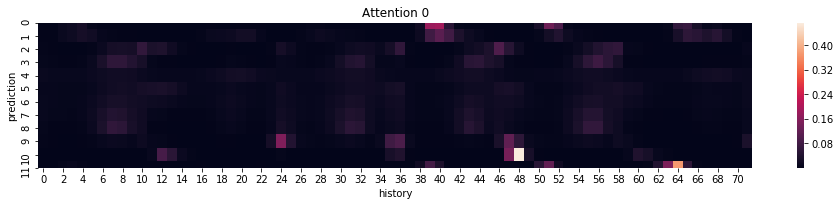

In [16]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

Text(0.5, 1.0, 'Seq2Seq 1 Attention prediction')

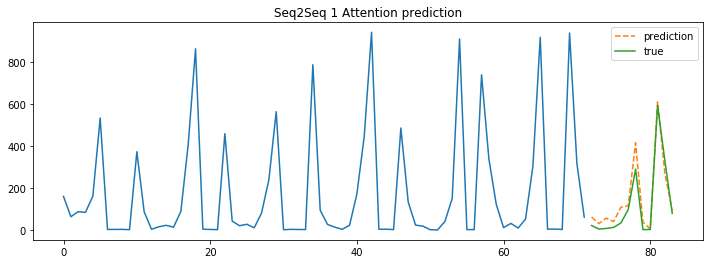

In [17]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 1 Attention prediction')

## 4. Seq2Seq(Attention 4)

In [18]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.677: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.41it/s]


epoch 1 / 100: train loss 0.923 val loss 0.996 RMSE 170.195
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 1.008: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.17it/s]


epoch 2 / 100: train loss 0.784 val loss 0.920 RMSE 163.112


batch 17 / 17, loss 0.726: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.43it/s]


epoch 3 / 100: train loss 0.695 val loss 0.888 RMSE 158.401


batch 17 / 17, loss 0.718: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.64it/s]


epoch 4 / 100: train loss 0.645 val loss 0.865 RMSE 156.283


batch 17 / 17, loss 0.660: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.21it/s]


epoch 5 / 100: train loss 0.655 val loss 0.856 RMSE 155.497


batch 17 / 17, loss 0.793: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 6 / 100: train loss 0.667 val loss 0.816 RMSE 151.449


batch 17 / 17, loss 0.810: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 7 / 100: train loss 0.656 val loss 0.825 RMSE 151.394


batch 17 / 17, loss 0.614: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.06it/s]


epoch 8 / 100: train loss 0.618 val loss 0.850 RMSE 156.119


batch 17 / 17, loss 0.655: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 9 / 100: train loss 0.626 val loss 0.769 RMSE 146.812


batch 17 / 17, loss 0.803: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 10 / 100: train loss 0.622 val loss 0.761 RMSE 146.675


batch 17 / 17, loss 0.560: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 11 / 100: train loss 0.553 val loss 0.730 RMSE 142.986


batch 17 / 17, loss 0.442: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 12 / 100: train loss 0.514 val loss 0.720 RMSE 141.234


batch 17 / 17, loss 0.428: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.73it/s]


epoch 13 / 100: train loss 0.524 val loss 0.812 RMSE 152.591


batch 17 / 17, loss 0.451: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.76it/s]


epoch 14 / 100: train loss 0.512 val loss 0.697 RMSE 139.355


batch 17 / 17, loss 0.502: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.08it/s]


epoch 15 / 100: train loss 0.475 val loss 0.714 RMSE 140.243


batch 17 / 17, loss 0.478: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 16 / 100: train loss 0.465 val loss 0.672 RMSE 135.254


batch 17 / 17, loss 0.435: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 17 / 100: train loss 0.444 val loss 0.635 RMSE 131.319


batch 17 / 17, loss 0.352: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.48it/s]


epoch 18 / 100: train loss 0.415 val loss 0.788 RMSE 151.004


batch 17 / 17, loss 0.490: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.04it/s]


epoch 19 / 100: train loss 0.476 val loss 0.681 RMSE 138.236


batch 17 / 17, loss 0.386: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 20 / 100: train loss 0.419 val loss 0.617 RMSE 129.330


batch 17 / 17, loss 0.447: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 21 / 100: train loss 0.393 val loss 0.597 RMSE 125.736


batch 17 / 17, loss 0.409: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.06it/s]


epoch 22 / 100: train loss 0.371 val loss 0.608 RMSE 128.711


batch 17 / 17, loss 0.297: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.04it/s]


epoch 23 / 100: train loss 0.344 val loss 0.598 RMSE 127.500


batch 17 / 17, loss 0.294: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.86it/s]


epoch 24 / 100: train loss 0.343 val loss 0.558 RMSE 121.502


batch 17 / 17, loss 0.368: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.41it/s]


epoch 25 / 100: train loss 0.317 val loss 0.541 RMSE 119.286


batch 17 / 17, loss 0.249: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.04it/s]


epoch 26 / 100: train loss 0.297 val loss 0.501 RMSE 114.263


batch 17 / 17, loss 0.270: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 27 / 100: train loss 0.290 val loss 0.508 RMSE 112.919


batch 17 / 17, loss 0.326: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.62it/s]


epoch 28 / 100: train loss 0.280 val loss 0.473 RMSE 108.555


batch 17 / 17, loss 0.209: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.05it/s]


epoch 29 / 100: train loss 0.258 val loss 0.539 RMSE 119.461


batch 17 / 17, loss 0.378: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.31it/s]


epoch 30 / 100: train loss 0.250 val loss 0.450 RMSE 104.083


batch 17 / 17, loss 0.181: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 31 / 100: train loss 0.234 val loss 0.433 RMSE 101.633


batch 17 / 17, loss 0.245: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.59it/s]


epoch 32 / 100: train loss 0.218 val loss 0.429 RMSE 100.816


batch 17 / 17, loss 0.181: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 33 / 100: train loss 0.206 val loss 0.417 RMSE 98.210


batch 17 / 17, loss 0.164: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.17it/s]


epoch 34 / 100: train loss 0.202 val loss 0.416 RMSE 97.676


batch 17 / 17, loss 0.169: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 35 / 100: train loss 0.202 val loss 0.394 RMSE 94.476


batch 17 / 17, loss 0.187: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.73it/s]


epoch 36 / 100: train loss 0.190 val loss 0.385 RMSE 92.936


batch 17 / 17, loss 0.172: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.76it/s]


epoch 37 / 100: train loss 0.184 val loss 0.384 RMSE 91.856


batch 17 / 17, loss 0.159: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.38it/s]


epoch 38 / 100: train loss 0.173 val loss 0.378 RMSE 90.529


batch 17 / 17, loss 0.139: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.32it/s]


epoch 39 / 100: train loss 0.170 val loss 0.364 RMSE 89.152


batch 17 / 17, loss 0.133: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 40 / 100: train loss 0.168 val loss 0.356 RMSE 87.589


batch 17 / 17, loss 0.140: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.70it/s]


epoch 41 / 100: train loss 0.160 val loss 0.352 RMSE 86.919


batch 17 / 17, loss 0.172: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.79it/s]


epoch 42 / 100: train loss 0.163 val loss 0.350 RMSE 86.714


batch 17 / 17, loss 0.147: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.84it/s]


epoch 43 / 100: train loss 0.157 val loss 0.345 RMSE 85.335


batch 17 / 17, loss 0.154: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.84it/s]


epoch 44 / 100: train loss 0.158 val loss 0.336 RMSE 84.675


batch 17 / 17, loss 0.155: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 45 / 100: train loss 0.156 val loss 0.332 RMSE 83.761


batch 17 / 17, loss 0.119: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 46 / 100: train loss 0.154 val loss 0.326 RMSE 83.068


batch 17 / 17, loss 0.142: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.16it/s]


epoch 47 / 100: train loss 0.153 val loss 0.322 RMSE 82.662


batch 17 / 17, loss 0.139: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.98it/s]


epoch 48 / 100: train loss 0.153 val loss 0.322 RMSE 82.432


batch 17 / 17, loss 0.292: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 49 / 100: train loss 0.155 val loss 0.325 RMSE 82.595


batch 17 / 17, loss 0.136: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.49it/s]


epoch 50 / 100: train loss 0.149 val loss 0.322 RMSE 82.354


batch 17 / 17, loss 0.136: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.53it/s]


epoch 51 / 100: train loss 0.146 val loss 0.322 RMSE 82.267


batch 17 / 17, loss 0.135: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.96it/s]


epoch 52 / 100: train loss 0.150 val loss 0.321 RMSE 82.180


batch 17 / 17, loss 0.287: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.96it/s]


epoch 53 / 100: train loss 0.152 val loss 0.321 RMSE 82.167


batch 17 / 17, loss 0.124: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 54 / 100: train loss 0.148 val loss 0.321 RMSE 82.069


batch 17 / 17, loss 0.124: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.06it/s]


epoch 55 / 100: train loss 0.146 val loss 0.321 RMSE 82.062


batch 17 / 17, loss 0.125: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 56 / 100: train loss 0.153 val loss 0.380 RMSE 89.539


batch 17 / 17, loss 0.315: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.68it/s]


epoch 57 / 100: train loss 0.354 val loss 0.777 RMSE 142.743


batch 17 / 17, loss 0.346: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.97it/s]


epoch 58 / 100: train loss 0.327 val loss 0.514 RMSE 112.341


batch 17 / 17, loss 0.223: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 59 / 100: train loss 0.233 val loss 0.381 RMSE 91.705


batch 17 / 17, loss 0.160: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 60 / 100: train loss 0.192 val loss 0.382 RMSE 94.261


batch 17 / 17, loss 0.143: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 61 / 100: train loss 0.161 val loss 0.327 RMSE 84.267


batch 17 / 17, loss 0.117: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 62 / 100: train loss 0.138 val loss 0.288 RMSE 78.352


batch 17 / 17, loss 0.127: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 63 / 100: train loss 0.130 val loss 0.265 RMSE 72.857


batch 17 / 17, loss 0.095: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.30it/s]


epoch 64 / 100: train loss 0.117 val loss 0.250 RMSE 70.633


batch 17 / 17, loss 0.122: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.78it/s]


epoch 65 / 100: train loss 0.118 val loss 0.274 RMSE 77.673


batch 17 / 17, loss 0.161: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.74it/s]


epoch 66 / 100: train loss 0.128 val loss 0.302 RMSE 85.412


batch 17 / 17, loss 0.107: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 67 / 100: train loss 0.135 val loss 0.314 RMSE 84.451


batch 17 / 17, loss 0.133: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.16it/s]


epoch 68 / 100: train loss 0.141 val loss 0.290 RMSE 81.245


batch 17 / 17, loss 0.185: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.05it/s]


epoch 69 / 100: train loss 0.207 val loss 0.642 RMSE 140.960


batch 17 / 17, loss 0.158: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.13it/s]


epoch 70 / 100: train loss 0.279 val loss 0.309 RMSE 87.017


batch 17 / 17, loss 0.149: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.67it/s]


epoch 71 / 100: train loss 0.157 val loss 0.260 RMSE 74.756


batch 17 / 17, loss 0.130: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.39it/s]


epoch 72 / 100: train loss 0.120 val loss 0.238 RMSE 68.235


batch 17 / 17, loss 0.111: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.90it/s]


epoch 73 / 100: train loss 0.105 val loss 0.226 RMSE 65.851


batch 17 / 17, loss 0.091: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.29it/s]


epoch 74 / 100: train loss 0.093 val loss 0.213 RMSE 62.564


batch 17 / 17, loss 0.075: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 75 / 100: train loss 0.086 val loss 0.206 RMSE 60.211


batch 17 / 17, loss 0.073: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 76 / 100: train loss 0.080 val loss 0.205 RMSE 58.981


batch 17 / 17, loss 0.126: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.00it/s]


epoch 77 / 100: train loss 0.078 val loss 0.201 RMSE 57.720


batch 17 / 17, loss 0.067: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.23it/s]


epoch 78 / 100: train loss 0.075 val loss 0.195 RMSE 56.816


batch 17 / 17, loss 0.073: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.51it/s]


epoch 79 / 100: train loss 0.074 val loss 0.190 RMSE 55.038


batch 17 / 17, loss 0.069: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.09it/s]


epoch 80 / 100: train loss 0.070 val loss 0.188 RMSE 53.911


batch 17 / 17, loss 0.104: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.36it/s]


epoch 81 / 100: train loss 0.067 val loss 0.185 RMSE 52.905


batch 17 / 17, loss 0.062: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 82 / 100: train loss 0.065 val loss 0.188 RMSE 54.240


batch 17 / 17, loss 0.070: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 83 / 100: train loss 0.065 val loss 0.187 RMSE 54.187


batch 17 / 17, loss 0.058: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.69it/s]


epoch 84 / 100: train loss 0.064 val loss 0.181 RMSE 52.694


batch 17 / 17, loss 0.073: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.86it/s]


epoch 85 / 100: train loss 0.063 val loss 0.178 RMSE 50.553


batch 17 / 17, loss 0.066: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 86 / 100: train loss 0.058 val loss 0.173 RMSE 49.432


batch 17 / 17, loss 0.052: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 87 / 100: train loss 0.058 val loss 0.167 RMSE 47.708


batch 17 / 17, loss 0.056: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 88 / 100: train loss 0.055 val loss 0.168 RMSE 47.859


batch 17 / 17, loss 0.049: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.91it/s]


epoch 89 / 100: train loss 0.054 val loss 0.168 RMSE 47.690


batch 17 / 17, loss 0.047: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 90 / 100: train loss 0.053 val loss 0.174 RMSE 49.835


batch 17 / 17, loss 0.054: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.90it/s]


epoch 91 / 100: train loss 0.055 val loss 0.166 RMSE 47.128


batch 17 / 17, loss 0.048: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 92 / 100: train loss 0.054 val loss 0.167 RMSE 46.258


batch 17 / 17, loss 0.052: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.70it/s]


epoch 93 / 100: train loss 0.051 val loss 0.163 RMSE 45.360


batch 17 / 17, loss 0.051: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 94 / 100: train loss 0.051 val loss 0.162 RMSE 47.719


batch 17 / 17, loss 0.046: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 95 / 100: train loss 0.050 val loss 0.159 RMSE 45.460


batch 17 / 17, loss 0.049: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 96 / 100: train loss 0.050 val loss 0.160 RMSE 46.757


batch 17 / 17, loss 0.032: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.73it/s]


epoch 97 / 100: train loss 0.048 val loss 0.156 RMSE 43.692


batch 17 / 17, loss 0.045: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 98 / 100: train loss 0.046 val loss 0.159 RMSE 43.819


batch 17 / 17, loss 0.050: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 99 / 100: train loss 0.046 val loss 0.151 RMSE 42.648


batch 17 / 17, loss 0.048: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.65it/s]


epoch 100 / 100: train loss 0.045 val loss 0.150 RMSE 43.208
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_100_0.150.pkl


In [19]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.025, valid loss: 0.150, test loss :0.301, test RMSE :62.883, 


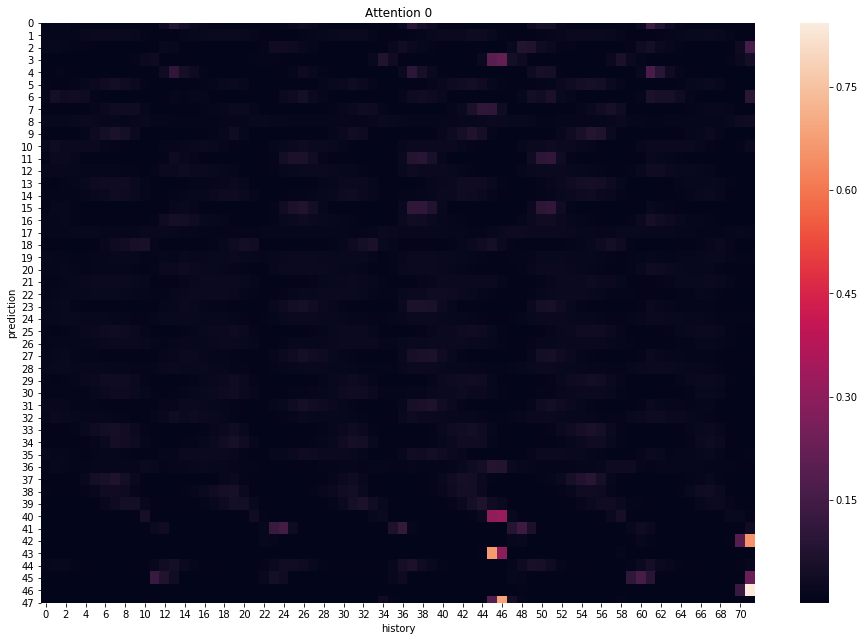

In [20]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

Text(0.5, 1.0, 'Seq2Seq 4 Attention prediction')

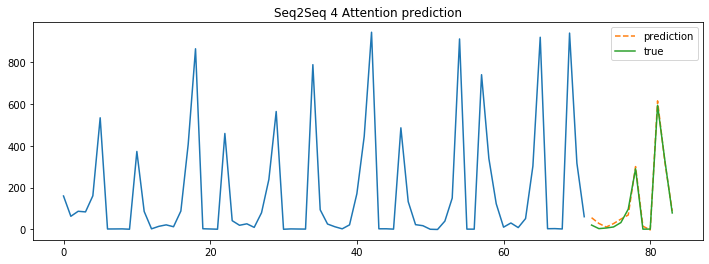

In [21]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 4 Attention prediction')

## 5. Simple WaveNet

In [22]:
dataset = SimpleWaveNetDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [23]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'dilation': [1, 2, 4, 8, 16, 32, 64],
        'dropout': 0.2,
        'residual_channels': 72,
        'teacher_forcing_rate': 0.5,
        'use_move_scale': True,
    }

compile_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
    'loss_fn': 'MSELoss',
}

In [24]:
model = SimpleWaveNet(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.886: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.24it/s]


epoch 1 / 100: train loss 1.066 val loss 1.187 RMSE 181.414
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.795: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 2 / 100: train loss 0.871 val loss 0.946 RMSE 162.442


batch 17 / 17, loss 0.595: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.37it/s]


epoch 3 / 100: train loss 0.746 val loss 0.874 RMSE 155.020


batch 17 / 17, loss 0.707: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.48it/s]


epoch 4 / 100: train loss 0.697 val loss 0.854 RMSE 153.092


batch 17 / 17, loss 0.761: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.51it/s]


epoch 5 / 100: train loss 0.685 val loss 0.850 RMSE 152.763


batch 17 / 17, loss 0.629: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.35it/s]


epoch 6 / 100: train loss 0.652 val loss 0.823 RMSE 150.023


batch 17 / 17, loss 0.455: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.56it/s]


epoch 7 / 100: train loss 0.577 val loss 0.789 RMSE 145.154


batch 17 / 17, loss 0.486: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.41it/s]


epoch 8 / 100: train loss 0.523 val loss 0.794 RMSE 145.677


batch 17 / 17, loss 0.386: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.52it/s]


epoch 9 / 100: train loss 0.474 val loss 0.732 RMSE 138.113


batch 17 / 17, loss 0.513: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.37it/s]


epoch 10 / 100: train loss 0.434 val loss 0.674 RMSE 131.373


batch 17 / 17, loss 0.355: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.46it/s]


epoch 11 / 100: train loss 0.398 val loss 0.684 RMSE 129.815


batch 17 / 17, loss 0.407: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.42it/s]


epoch 12 / 100: train loss 0.372 val loss 0.663 RMSE 127.641


batch 17 / 17, loss 0.389: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.59it/s]


epoch 13 / 100: train loss 0.346 val loss 0.657 RMSE 125.977


batch 17 / 17, loss 0.294: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 14 / 100: train loss 0.327 val loss 0.600 RMSE 118.094


batch 17 / 17, loss 0.234: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.32it/s]


epoch 15 / 100: train loss 0.304 val loss 0.605 RMSE 121.656


batch 17 / 17, loss 0.273: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.52it/s]


epoch 16 / 100: train loss 0.290 val loss 0.605 RMSE 118.888


batch 17 / 17, loss 0.319: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.11it/s]


epoch 17 / 100: train loss 0.279 val loss 0.529 RMSE 109.943


batch 17 / 17, loss 0.250: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.46it/s]


epoch 18 / 100: train loss 0.262 val loss 0.519 RMSE 109.220


batch 17 / 17, loss 0.220: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.40it/s]


epoch 19 / 100: train loss 0.249 val loss 0.476 RMSE 103.684


batch 17 / 17, loss 0.212: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.38it/s]


epoch 20 / 100: train loss 0.241 val loss 0.481 RMSE 104.596


batch 17 / 17, loss 0.239: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.51it/s]


epoch 21 / 100: train loss 0.235 val loss 0.454 RMSE 100.815


batch 17 / 17, loss 0.187: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.50it/s]


epoch 22 / 100: train loss 0.225 val loss 0.459 RMSE 99.800


batch 17 / 17, loss 0.204: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.32it/s]


epoch 23 / 100: train loss 0.224 val loss 0.399 RMSE 92.135


batch 17 / 17, loss 0.201: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 24 / 100: train loss 0.211 val loss 0.415 RMSE 94.605


batch 17 / 17, loss 0.268: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.36it/s]


epoch 25 / 100: train loss 0.214 val loss 0.378 RMSE 89.021


batch 17 / 17, loss 0.235: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.29it/s]


epoch 26 / 100: train loss 0.206 val loss 0.369 RMSE 89.276


batch 17 / 17, loss 0.172: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.21it/s]


epoch 27 / 100: train loss 0.201 val loss 0.350 RMSE 87.998


batch 17 / 17, loss 0.204: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.31it/s]


epoch 28 / 100: train loss 0.200 val loss 0.334 RMSE 86.301


batch 17 / 17, loss 0.179: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.37it/s]


epoch 29 / 100: train loss 0.191 val loss 0.323 RMSE 83.384


batch 17 / 17, loss 0.296: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.34it/s]


epoch 30 / 100: train loss 0.195 val loss 0.335 RMSE 84.833


batch 17 / 17, loss 0.232: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.15it/s]


epoch 31 / 100: train loss 0.195 val loss 0.321 RMSE 83.504


batch 17 / 17, loss 0.201: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.35it/s]


epoch 32 / 100: train loss 0.189 val loss 0.311 RMSE 82.794


batch 17 / 17, loss 0.209: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.43it/s]


epoch 33 / 100: train loss 0.190 val loss 0.302 RMSE 82.757


batch 17 / 17, loss 0.200: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.23it/s]


epoch 34 / 100: train loss 0.181 val loss 0.292 RMSE 79.460


batch 17 / 17, loss 0.164: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.39it/s]


epoch 35 / 100: train loss 0.185 val loss 0.305 RMSE 82.485


batch 17 / 17, loss 0.144: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 36 / 100: train loss 0.175 val loss 0.299 RMSE 80.707


batch 17 / 17, loss 0.205: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.19it/s]


epoch 37 / 100: train loss 0.178 val loss 0.282 RMSE 78.681


batch 17 / 17, loss 0.197: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.21it/s]


epoch 38 / 100: train loss 0.176 val loss 0.268 RMSE 76.559


batch 17 / 17, loss 0.168: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.26it/s]


epoch 39 / 100: train loss 0.178 val loss 0.271 RMSE 76.149


batch 17 / 17, loss 0.176: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.36it/s]


epoch 40 / 100: train loss 0.180 val loss 0.265 RMSE 74.955


batch 17 / 17, loss 0.136: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.27it/s]


epoch 41 / 100: train loss 0.177 val loss 0.265 RMSE 75.258


batch 17 / 17, loss 0.150: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.29it/s]


epoch 42 / 100: train loss 0.178 val loss 0.265 RMSE 74.844


batch 17 / 17, loss 0.232: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.18it/s]


epoch 43 / 100: train loss 0.175 val loss 0.257 RMSE 73.949


batch 17 / 17, loss 0.151: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.38it/s]


epoch 44 / 100: train loss 0.175 val loss 0.253 RMSE 74.295


batch 17 / 17, loss 0.175: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.27it/s]


epoch 45 / 100: train loss 0.180 val loss 0.256 RMSE 73.614


batch 17 / 17, loss 0.197: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.12it/s]


epoch 46 / 100: train loss 0.176 val loss 0.261 RMSE 74.830


batch 17 / 17, loss 0.190: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.36it/s]


epoch 47 / 100: train loss 0.173 val loss 0.259 RMSE 74.321


batch 17 / 17, loss 0.135: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.39it/s]


epoch 48 / 100: train loss 0.171 val loss 0.257 RMSE 73.983


batch 17 / 17, loss 0.134: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.34it/s]


epoch 49 / 100: train loss 0.166 val loss 0.258 RMSE 74.693


batch 17 / 17, loss 0.127: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.32it/s]


epoch 50 / 100: train loss 0.167 val loss 0.257 RMSE 74.439


batch 17 / 17, loss 0.220: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.39it/s]


epoch 51 / 100: train loss 0.175 val loss 0.255 RMSE 74.004


batch 17 / 17, loss 0.128: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.12it/s]


epoch 52 / 100: train loss 0.169 val loss 0.255 RMSE 73.988


batch 17 / 17, loss 0.172: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.36it/s]


epoch 53 / 100: train loss 0.169 val loss 0.255 RMSE 74.033


batch 17 / 17, loss 0.140: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.43it/s]


epoch 54 / 100: train loss 0.166 val loss 0.255 RMSE 74.084


batch 17 / 17, loss 0.156: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.19it/s]


epoch 55 / 100: train loss 0.171 val loss 0.256 RMSE 74.097


batch 17 / 17, loss 0.182: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.29it/s]


epoch 56 / 100: train loss 0.174 val loss 0.266 RMSE 77.042
early_stopping ! current epochs: 56, best epochs: 44.
model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleWaveNet_epoch_44_0.253.pkl


In [25]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f} '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f} '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f} '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.114 valid loss: 0.253 test loss :0.374 test RMSE :90.149, 


In [26]:
val_set[0].keys()

dict_keys(['enc_inputs', 'dec_outputs'])

Text(0.5, 1.0, 'Simple WaveNet prediction')

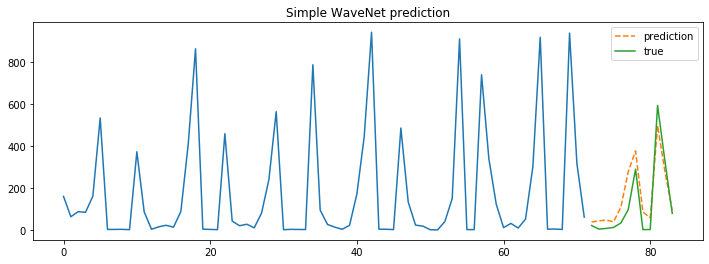

In [27]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[1]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[h], pred[h], dec_outputs[h])
plt.title('Simple WaveNet prediction')

## 6. Summary

| model | num of attention | RMSE(test) | loss(test) | loss(val) | loss(train)|
|:-:| :-: | :-:| :-:| :-:| :-:|
| SimpleSeq2Seq | / | 141.54 | 0.725|0.682|0.476|
| Seq2Seq| 0| 120.7| 0.571| 0.491| 0.279|
| Seq2Seq| 1| 113.9| 0.532| 0.427| 0.222|
| Seq2Seq| 4| 67.5 | 0.341| 0.204| 0.028|
| SimpleWaveNet| / | 84.5 | 0.355 | 0.237| 0.093|